<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Making Linear Regression Work Better

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings("ignore")

In [70]:
# Run this before any other code cell
# This downloads the csv data files into the same directory where you have saved this notebook

import urllib.request
from pathlib import Path
import os
path = Path()

# Dictionary of file names and download links
files = {'Auto.csv':'https://storage.googleapis.com/aipi_datasets/Auto.csv'}

# Download each file
for key,value in files.items():
    filename = path/key
    url = value
    # If the file does not already exist in the directory, download it
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url,filename)

## Polynomial Regression
To easily implement polynomial regression in Scikit Learn we can use the PolynomialFeatures class to transform our input data to any degree

In [50]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([[2], [3], [4]])
poly = PolynomialFeatures(3, include_bias=True)
poly.fit_transform(x)

array([[ 1.,  2.,  4.,  8.],
       [ 1.,  3.,  9., 27.],
       [ 1.,  4., 16., 64.]])

In [51]:
# Read in data
data = pd.read_csv('Auto.csv')
# Remove rows with missing values
data = data[data['horsepower'] != '?']
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [52]:
# Define the features and target (X and y)
X = data['horsepower'].astype(int).values.reshape(-1,1)
y = data['mpg'].astype(float)

# Split into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

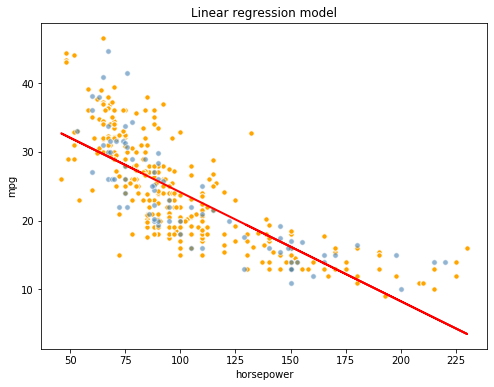

MSE train: 24.430, test: 22.026


In [53]:
# Let's use a Simple Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train,y_train)

# Look at how well the model is fitting the data
plt.figure(figsize=(8,6))
plt.scatter(X_train,y_train,color='orange',edgecolor='white',s=30,label='train') # Plot training data
plt.scatter(X_test,y_test,color='steelblue',edgecolor='white',s=30,alpha=0.6,label='test') # Plot test data
plt.plot(X,model.predict(X),color='red',lw=2,label='predictions') # Plot predictions
plt.title('Linear regression model')
plt.xlabel('horsepower')
plt.ylabel('mpg')
#plt.legend()
plt.show()

# Get the predictions
train_preds = model.predict(X_train)
test_preds = model.predict(X_test)

# Calculate MSE
train_mse = 1/len(y_train)*np.sum((train_preds-y_train)**2)
test_mse = 1/len(y_test)*np.sum((test_preds-y_test)**2)
print('MSE train: {:.3f}, test: {:.3f}'.format(train_mse,test_mse))

While our model appears to do an ok job fitting the data, we can see that there is room for improvement.  There appears to be a non-linear relationship between horsepower and mpg.  Let's use a polynomial regression to see if we can improve the model

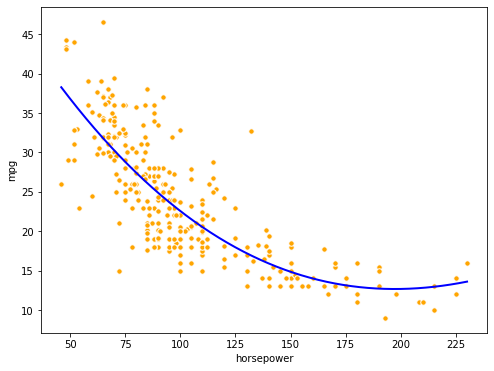

MSE train: 19.728, test: 15.911


In [54]:
# Create polynomial features of degree i
i=3
# Instantiate the polynomial transformation
poly_transform = PolynomialFeatures(degree=i)

# Apply the transformation to the training and test sets
X_train_poly = poly_transform.fit_transform(X_train)
X_test_poly = poly_transform.transform(X_test)

# Fit model to transformed X_train
poly_model = LinearRegression()
poly_model.fit(X_train_poly,y_train)

# Get the predictions
train_preds_poly = poly_model.predict(X_train_poly)
test_preds_poly = poly_model.predict(X_test_poly)

# Calculate MSE
train_mse = 1/len(y_train)*np.sum((train_preds_poly-y_train)**2)
test_mse = 1/len(y_test)*np.sum((test_preds_poly-y_test)**2)


# Look at how well the model is fitting the data
plt.figure(figsize=(8,6))
plt.scatter(X_train,y_train,color='orange',edgecolor='white',s=30,label='train') # Plot training data
#plt.scatter(X_test,y_test,color='steelblue',edgecolor='white',s=30,alpha=0.6,label='test') # Plot test data
# Plot the predictions from the polynomial model and our original normal model
x_plot = np.linspace(X.min(),X.max()).reshape(-1,1)
preds_plot = poly_model.predict(poly_transform.transform(x_plot))
plt.plot(x_plot,preds_plot,color='blue',lw=2,label='Polynomial model preds') 
#plt.plot(x_plot,model.predict(x_plot),color='red',lw=2,label='Linear predictions') # Plot predictions

plt.xlabel('horsepower')
plt.ylabel('mpg')
#plt.title('Polynomial regression model, degree = {}'.format(i))
#plt.legend()
plt.show()

print('MSE train: {:.3f}, test: {:.3f}'.format(train_mse,test_mse))

In [55]:
# Let's see what our new training data looks like with the polynomial features
print(X_train[:3])
print()
print(X_train_poly[:3])

[[ 70]
 [100]
 [ 70]]

[[1.00e+00 7.00e+01 4.90e+03 3.43e+05]
 [1.00e+00 1.00e+02 1.00e+04 1.00e+06]
 [1.00e+00 7.00e+01 4.90e+03 3.43e+05]]


## LASSO Regression

In [56]:
# Define the features and target (X and y)
X = data[['cylinders','displacement','weight','horsepower','acceleration','year']].astype(int)
y = data['mpg'].astype(float)

# Split into training and test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

Let's start with a normal linear model to get a baseline

In [57]:
# Let's start with a normal linear model to get a baseline
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)
test_preds = lin_model.predict(X_test)
mse_test = 1/y_test.shape[0]*np.sum((test_preds-y_test)**2)
print('MSE on the test set is {:.3f}'.format(mse_test))

MSE on the test set is 11.953


Now let's try a LASSO model.  First we need to scale our data

In [58]:
# First we scale our data - remember, only use the training data to fit the scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run a LASSO model using the default lambda (alpha in SKLearn) of 1.0
from sklearn.linear_model import Lasso
lasso_model = Lasso()
lasso_model.fit(X_train_scaled,y_train)
test_preds = lasso_model.predict(X_test_scaled)
mse_test = 1/y_test.shape[0]*np.sum((test_preds-y_test)**2)
print('MSE on the test set is {:.3f}'.format(mse_test))

MSE on the test set is 13.124


y = 23.482 + -0.000*cylinders + -0.000*displacement + -4.793*weight + -0.092*horsepower + 0.000*acceleration + 1.951*year


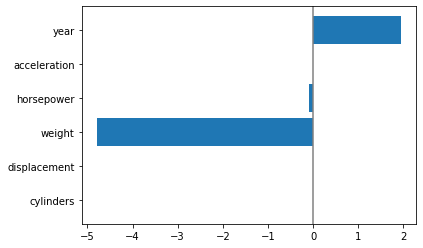

In [59]:
# Get the equation for the LASSO model
coef = lasso_model.coef_
intercept = lasso_model.intercept_

# Print out the equation
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X.columns)])
print(equation)

# Plot the coefficients
plt.barh(X.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()

As we can see above, our LASSO model at lambda/alpha=1.0 zeroed out several of our model coefficients, leaving only weight, horsepower, and year in our model.

Let's look for the optimal value of the lambda (alpha) hyperparameter.  Since the possible range of values for lambda is 0 to infinity, let's start with a big picture analysis and then zoom in

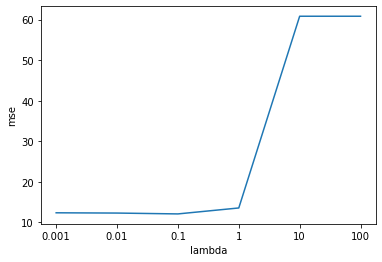

In [60]:
# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
lambda_values = [10**i for i in range(-3,3,1)]

kf = KFold(n_splits=10)
lasso_errors = []

for lambda_val in lambda_values:
    lasso_model = Lasso(alpha=lambda_val)
    
    # Run cross-validation
    mse_folds = []
    for (train_idx,val_idx) in kf.split(X=X_train_scaled,y=y_train):
        # Split training and validation sets for each fold
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit model to the training data for this iteration
        lasso_model.fit(X_fold_train,y_fold_train)

        # Get predictions for the validation fold and calculate mse
        val_preds = lasso_model.predict(X_fold_val)
        mse_val = 1/y_fold_val.shape[0]*np.sum((val_preds-y_fold_val)**2)
        mse_folds.append(mse_val)
        
    lasso_errors.append(np.mean(mse_folds))
    
# Plot the mse vs lambda/alpha values, using log scale for lambda values
plt.plot(np.log(lambda_values),lasso_errors)
plt.xticks(ticks=np.log(lambda_values),labels=lambda_values)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

Now let's zoom in to identify the optimal lambda value

Optimal lambda value is 0.050


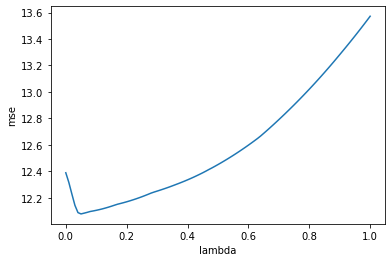

In [61]:
# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
kf = KFold(n_splits=10)

lambda_values = np.arange(0.,1.01,0.01)

lasso_errors = []
for lambda_val in lambda_values:
    lasso_model = Lasso(alpha=lambda_val)
    
    # Run cross-validation
    mse_folds = []
    for (train_idx,val_idx) in kf.split(X=X_train_scaled,y=y_train):
        # Split training and validation sets for each fold
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit model to the training data for this iteration
        lasso_model.fit(X_fold_train,y_fold_train)

        # Get predictions for the validation fold and calculate mse
        val_preds = lasso_model.predict(X_fold_val)
        mse_val = 1/y_fold_val.shape[0]*np.sum((val_preds-y_fold_val)**2)
        mse_folds.append(mse_val)
        
    lasso_errors.append(np.mean(mse_folds))
    
# Get the optimal lambda/alpha
opt_lambda_lasso = lambda_values[np.argmin(lasso_errors)]
print('Optimal lambda value is {:.3f}'.format(opt_lambda_lasso))
    
# Plot the mse vs lambda/alpha values
plt.plot(lambda_values,lasso_errors)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

### Based on what we learned in the lecture, why might higher penalty values for the LASSO not work well in this particular case?

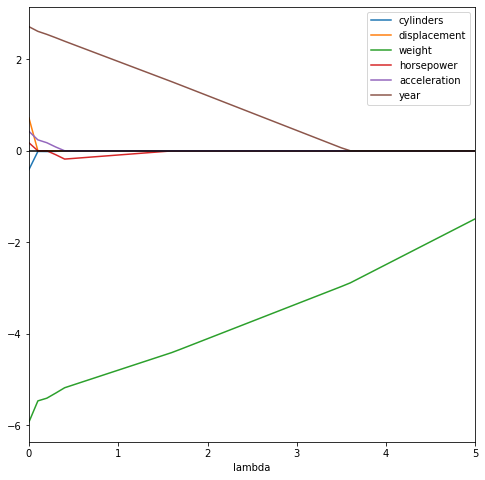

In [62]:
# Now let's vary the lambda (alpha) hyperparameter and visualize the change in coefficients
coeff_vals = {var:[] for var in X.columns} # Dict to hold values of each coefficient

lambda_values = np.arange(0.,5.01,0.1)
for lambda_val in lambda_values:
    lasso_model = Lasso(alpha=lambda_val)
    # Fit model to the training data
    lasso_model.fit(X_train_scaled,y_train)
    # Get coefficients to plot
    coef = lasso_model.coef_
    for coef,var in zip(coef,X.columns):
        coeff_vals[var].append(coef)
        
# Plot the coefficient values
plt.figure(figsize=(8,8))
for var in coeff_vals.keys():
    plt.plot(lambda_values,coeff_vals[var],label=var)
plt.plot([0,np.max(lambda_values)],[0,0],color='black')
plt.xlim(0,np.max(lambda_values))
plt.legend()
plt.xlabel('lambda')
plt.show()


In [63]:
# Calculate the mse on the test set using the optimal lambda value
lasso_model = Lasso(alpha=opt_lambda_lasso)
lasso_model.fit(X_train_scaled,y_train)
test_preds = lasso_model.predict(X_test_scaled)
mse_test = 1/y_test.shape[0]*np.sum((test_preds-y_test)**2)
print('MSE on the test set is {:.3f}'.format(mse_test))

MSE on the test set is 11.905


y = 23.482 + -0.013*cylinders + -0.000*displacement + -5.493*weight + -0.000*horsepower + 0.270*acceleration + 2.643*year


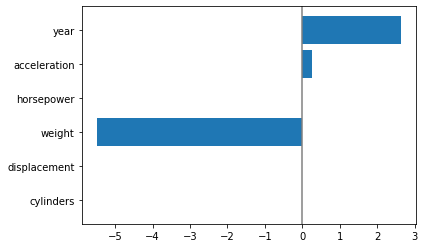

In [64]:
# Get the equation for the LASSO model
coef = lasso_model.coef_
intercept = lasso_model.intercept_

# Print out the equation
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X.columns)])
print(equation)

# Plot the coefficients
plt.barh(X.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()

## Ridge Regression

In [65]:
# First we scale our data - remember, only use the training data to fit the scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Run a Ridge model using the default lambda (alpha)
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled,y_train)
test_preds = ridge_model.predict(X_test_scaled)
mse_test = 1/y_test.shape[0]*np.sum((test_preds-y_test)**2)
print('MSE on the test set is {:.3f}'.format(mse_test))

MSE on the test set is 11.917


Of the values evaluated, the optimal lambda value is 1.000


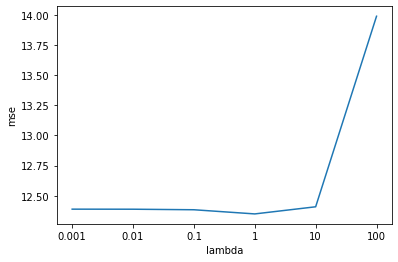

In [66]:
# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
lambda_values = [10**i for i in range(-3,3,1)]

kf = KFold(n_splits=10)
ridge_errors = []

for lambda_val in lambda_values:
    ridge_model = Ridge(alpha=lambda_val)
    
    # Run cross-validation
    mse_folds = []
    for (train_idx,val_idx) in kf.split(X=X_train_scaled,y=y_train):
        # Split training and validation sets for each fold
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit model to the training data for this iteration
        ridge_model.fit(X_fold_train,y_fold_train)

        # Get predictions for the validation fold and calculate mse
        val_preds = ridge_model.predict(X_fold_val)
        mse_val = 1/y_fold_val.shape[0]*np.sum((val_preds-y_fold_val)**2)
        mse_folds.append(mse_val)
        
    ridge_errors.append(np.mean(mse_folds))
    
# Get the optimal lambda/alpha
opt_lambda_ridge = lambda_values[np.argmin(ridge_errors)]
print('Of the values evaluated, the optimal lambda value is {:.3f}'.format(opt_lambda_ridge))
    
# Plot the mse vs lambda/alpha values
plt.plot(np.log(lambda_values),ridge_errors)
plt.xticks(ticks=np.log(lambda_values),labels=lambda_values)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

Of the values evaluated, the optimal lambda value is 3.500


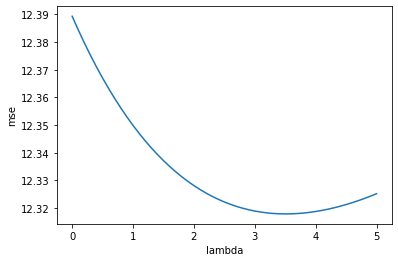

In [67]:
# Now let's vary the lambda (alpha) hyperparameter and find the optimal value using cross-validation
lambda_values = np.arange(0.,5.01,0.1)

kf = KFold(n_splits=10)
ridge_errors = []

for lambda_val in lambda_values:
    ridge_model = Ridge(alpha=lambda_val)
    
    
    # Run cross-validation
    mse_folds = []
    for (train_idx,val_idx) in kf.split(X=X_train_scaled,y=y_train):
        # Split training and validation sets for each fold
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Fit model to the training data for this iteration
        ridge_model.fit(X_fold_train,y_fold_train)

        # Get predictions for the validation fold and calculate mse
        val_preds = ridge_model.predict(X_fold_val)
        mse_val = 1/y_fold_val.shape[0]*np.sum((val_preds-y_fold_val)**2)
        mse_folds.append(mse_val)
        
    ridge_errors.append(np.mean(mse_folds))
    
# Get the optimal lambda/alpha
opt_lambda_ridge = lambda_values[np.argmin(ridge_errors)]
print('Of the values evaluated, the optimal lambda value is {:.3f}'.format(opt_lambda_ridge))
    
# Plot the mse vs lambda/alpha values
plt.plot(lambda_values,ridge_errors)
plt.xlabel('lambda')
plt.ylabel('mse')
plt.show()

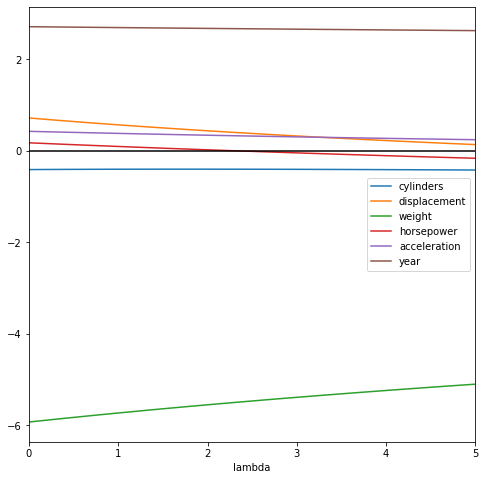

In [68]:
# Now let's vary the lambda (alpha) hyperparameter and visualize the change in coefficients
coeff_vals = {var:[] for var in X.columns} # Dict to hold values of each coefficient

lambda_values = np.arange(0.,5.05,0.05)
for lambda_val in lambda_values:
    ridge_model = Ridge(alpha=lambda_val)
    # Fit model to the training data
    ridge_model.fit(X_train_scaled,y_train)
    # Get coefficients to plot
    coef = ridge_model.coef_
    for coef,var in zip(coef,X.columns):
        coeff_vals[var].append(coef)
        
# Plot the coefficient values
plt.figure(figsize=(8,8))
for var in coeff_vals.keys():
    plt.plot(lambda_values,coeff_vals[var],label=var)
plt.plot([0,np.max(lambda_values)],[0,0],color='black')
plt.xlim(0,np.max(lambda_values))
plt.legend()
plt.xlabel('lambda')
plt.show()

MSE on the test set is 11.862

Equation of final ridge model:
y = 23.482 + -0.408*cylinders + 0.272*displacement + -5.310*weight + -0.077*horsepower + 0.287*acceleration + 2.649*year


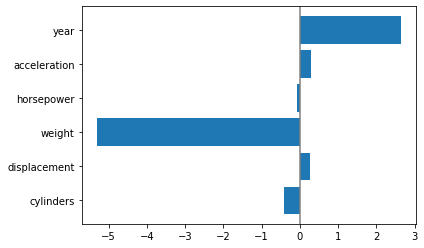

In [69]:
# Calculate the mse on the test set using the optimal lambda value
ridge_model = Ridge(alpha=opt_lambda_ridge)
ridge_model.fit(X_train_scaled,y_train)
test_preds = ridge_model.predict(X_test_scaled)
mse_test = 1/y_test.shape[0]*np.sum((test_preds-y_test)**2)
print('MSE on the test set is {:.3f}'.format(mse_test))

# Display final model and plot the coefficients
coef = ridge_model.coef_
intercept = ridge_model.intercept_
equation = 'y = {:.3f} + '.format(intercept) + ' + '.join(['{:.3f}*{}'.format(coef,var) for coef,var in zip(coef,X.columns)])
print()
print('Equation of final ridge model:')
print(equation)
plt.barh(X.columns,coef)
plt.axvline(x=0, color='.5')
plt.show()